In [1]:
import numpy as np
import pyfits
import math
from math import log10
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
from matplotlib import rc
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7
os.chdir('/Users/nitya/Work/Data/Project1/measurements')
from scipy import interpolate
import corner
file_alpha = open(r'SFRP_edge_corrected.pkl', 'rb')
d = pickle.load(file_alpha,encoding ='latin1')
file_alpha.close()

file_beta = open(r'tracer_bin_magphys.pkl', 'rb')
a = pickle.load(file_beta,encoding ='latin1')
file_beta.close()

file_gamma = open(r'tracer_bin_opt_inf.pkl', 'rb')
b = pickle.load(file_gamma,encoding ='latin1')
file_gamma.close()


In [2]:
#Calculating UV SFR's



def jansky(flux,kcorrect):
    flux_in_Jy = flux*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return flux_in_Jy


#Inverse Variance in Fluxes: (Input Flux inverse variance in Nmgy^-2)
def jansky_err(flux,kcorrect):
    Jy_err = (flux**(-0.5))*3631*(10.0**(-9.0))*(10**(kcorrect/(-2.5)))
    return Jy_err

def uvsfr(id,z,fmag,nmag,rmag,f_flux):
    fn = fmag - nmag
    opt = nmag - rmag   # N-r
    
    #Luminosity Distance
    dist = WMAP7.comoving_distance(z).value
    ldist = (1+z)*dist
    
    #calculating Attenuation 'a'
    if opt>=4.0:
        if fn < 0.95:
            a = 3.32*float(fn) + 0.22
        else:
            a = 3.37
    else:
        if fn < 0.90:
            a = 2.99*float(fn) +0.27
        else:
            a = 2.96

    lum = 4*3.14159*(ldist**2.0)*(3.087**2.0)*(10**(25.0 +(a/2.5)))*f_flux  #Luminosity
    sfr = 1.08*(10**(-28.0))*abs(lum)
    return sfr

In [3]:

# n_flux = jansky(d['NMGY'][:,1], d['KCORRECT'][:,1])
fmag = d['ABSMAG'][:,0]
nmag = d['ABSMAG'][:,1]
rmag = d['ABSMAG'][:,4]
z = d['Z']
ind = d['NSAID']
f_flux = np.asarray([jansky(d['NMGY'][:,0][i], d['KCORRECT'][:,0][i]) for i in range(len(z))])


uvs = np.asarray([uvsfr(ind[i],z[i],fmag[i],nmag[i],rmag[i],f_flux[i]) for i in range(len(z))])

uv = np.log10(uvs)
lm = np.log10(d['MASS'])
uvssfr = np.asarray([np.log10(uvs[i] /d['MASS'][i]) for i in range(len(z))])
print(np.shape(d), np.shape(uvssfr))

nsa = np.asarray(d['NSAID'])
opt = np.asarray([d['ABSMAG'][:,1][i] - d['ABSMAG'][:,4][i] for i in range(len(d['NSAID']))])
inf = np.asarray([d['W1MAG'][i] - d['W3MAG'][i] for i in range(len(d['NSAID']))])

points1 = np.column_stack((b[:,1],b[:,2]))
points2 = np.column_stack((opt,inf))
sfr = interpolate.griddata(points1,a[:,1],points2, method = 'linear')

print(sfr[0:10])

(61084,) (61084,)
[-10.21664983 -10.3440649   -9.91430983 -10.6823062  -13.28396563
 -10.05871764  -9.93409593 -10.27000432 -13.41983492 -13.4183362 ]


In [4]:
print(len(sfr))
indz = np.isnan(sfr)
print(len(sfr[indz]))
inds = np.invert(indz)
print(len(sfr[inds]))

ra = d['RA'][inds]
absmags = d['ABSMAG'][inds]
dec = d['DEC'][inds]
z = d['Z'][inds]

mass = d['MASS'][inds]
magphys = sfr[inds]
print(mass[0:10])
uvssfr = uvssfr[inds]
lm = np.log10(mass)
uvsfr = np.asarray([lm[i] + uvssfr[i] for i in range(len(magphys))])
magsfr = np.asarray([lm[i] + magphys[i] for i in range(len(magphys))])
opt = opt[inds]
inf = inf[inds]
nsaid = d['NSAID'][inds]
f_flux = f_flux[inds]
fmag = fmag[inds]
nmag = nmag[inds]
rmag = rmag[inds]

61084
38
61046
[1.7028572e+10 2.1265178e+09 6.0569293e+09 7.2571500e+09 6.3540772e+09
 1.1502422e+10 9.0787492e+09 3.0113930e+09 1.3764565e+10 2.2536303e+10]


In [5]:
# print(len(ra))
# stuff = np.column_stack((nsaid,ra,dec,z,absmags))

# afile = open(r'nsaid_ra_dec_z_absmags.pkl', 'wb')
# pickle.dump(stuff, afile)
# afile.close()

In [6]:
file_gamma = open(r'nsaid_env.pkl', 'rb')
e = pickle.load(file_gamma,encoding ='latin1')
file_gamma.close()

eid = np.asarray(e[:,0])
#let's remove the ones that are not in the edge corrected SFRP sample;
index0 = np.in1d(eid,nsaid)
print(len(eid[index0]))

env = np.asarray(e[:,1][index0])


61046


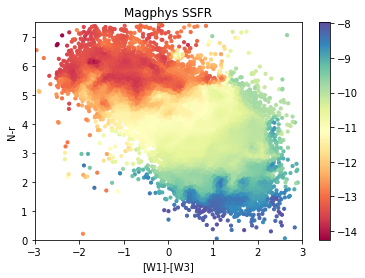

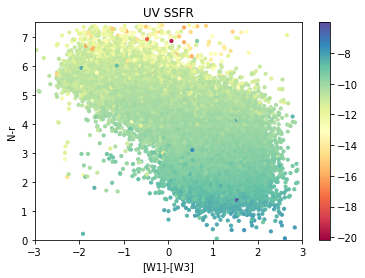

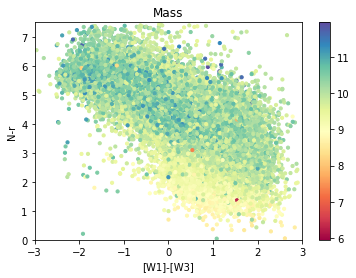

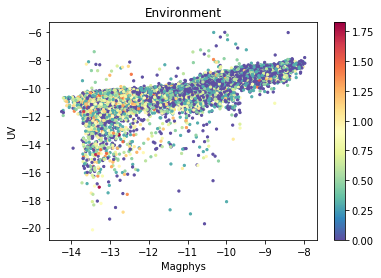

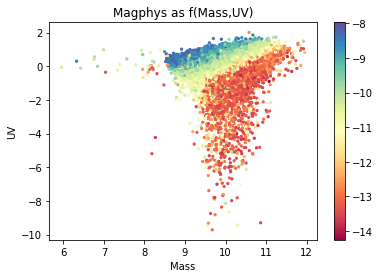

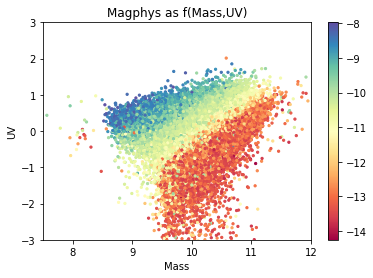

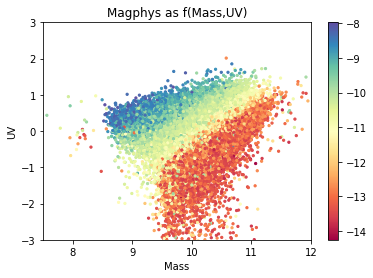

In [7]:
cs = plt.scatter(inf,opt, c = magphys, cmap = plt.cm.Spectral, s = 10)
plt.colorbar()
plt.xlim(-3,3)
plt.ylim(0,7.5)
plt.xlabel('[W1]-[W3]')
plt.ylabel('N-r')
plt.title('Magphys SSFR')
#plt.savefig('interpolated_magphys.pdf')
plt.show()

plt.scatter(inf,opt, c = uvssfr, cmap = plt.cm.Spectral, s = 10)
plt.colorbar()
plt.xlim(-3,3)
plt.ylim(0,7.5)
plt.xlabel('[W1]-[W3]')
plt.ylabel('N-r')
plt.title('UV SSFR')
#plt.savefig('interpolated_uvssfr.pdf')
plt.show()

plt.scatter(inf,opt, c = lm, cmap = plt.cm.Spectral, s = 10)
plt.colorbar()
plt.xlim(-3,3)
plt.ylim(0,7.5)
plt.xlabel('[W1]-[W3]')
plt.ylabel('N-r')
plt.title('Mass')
#plt.savefig('interpolated_mass.pdf')
plt.show()

plt.scatter(magphys, uvssfr, c = np.log10(env), cmap = plt.cm.Spectral_r, s=5)
plt.xlabel('Magphys')
plt.ylabel('UV')
plt.title('Environment')
plt.colorbar()
plt.show()

plt.scatter(lm, uvsfr, c = magphys, cmap = plt.cm.Spectral, s=5)
plt.xlabel('Mass')
plt.ylabel('UV')
plt.title('Magphys as f(Mass,UV)')
plt.colorbar()
#plt.savefig('interp_uv_mass_magphys1.pdf')
plt.show()

plt.scatter(lm, uvsfr, c = magphys, cmap = plt.cm.Spectral, s=5)
plt.xlim(7.5,12)
plt.ylim(-3,3)
plt.xlabel('Mass')
plt.ylabel('UV')
plt.title('Magphys as f(Mass,UV)')
plt.colorbar()
#plt.savefig('interp_uv_mass_magphys2.pdf')
plt.show()

plt.scatter(lm, uvsfr, c = magphys, cmap = plt.cm.Spectral, s=5)
plt.xlim(7.5,12)
plt.ylim(-3,3)
plt.xlabel('Mass')
plt.ylabel('UV')
plt.title('Magphys as f(Mass,UV)')
plt.colorbar()
#plt.savefig('interp_uv_mass_magphys2.pdf')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


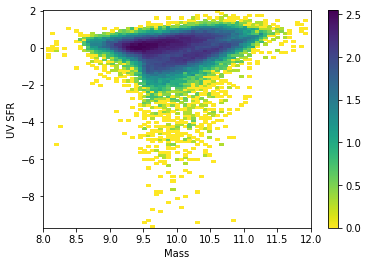

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


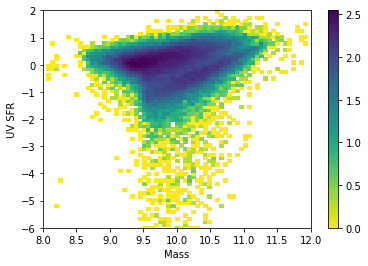

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


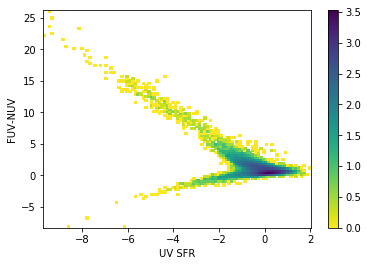

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log10


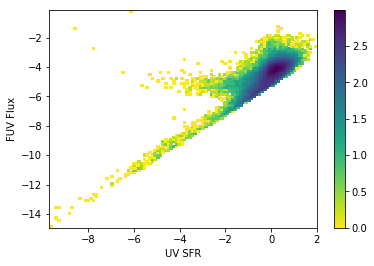

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log10


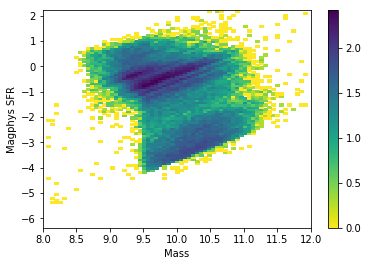

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10


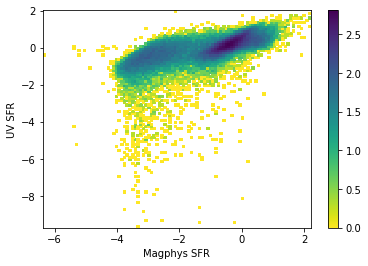

In [8]:
fn = np.asarray([fmag[i]-nmag[i] for i in range(len(fmag))])

t = binned_statistic_2d(lm,uvsfr,ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('UV SFR')
plt.xlim(8.0,12.0)
#plt.ylim(-6.0,2.0)
plt.show()




t = binned_statistic_2d(lm,uvsfr,ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('UV SFR')
plt.xlim(8.0,12.0)
plt.ylim(-6.0,2.0)
plt.show()

t = binned_statistic_2d(uvsfr,fn,ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('UV SFR')
plt.ylabel('FUV-NUV')
#plt.xlim(8.0,12.0)
#plt.ylim(-6.0,2.0)
plt.show()

t = binned_statistic_2d(uvsfr,np.log10(f_flux),ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('UV SFR')
plt.ylabel('FUV Flux')
plt.show()

t = binned_statistic_2d(lm,magsfr,ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('Mass')
plt.ylabel('Magphys SFR')
plt.xlim(8.0,12.0)
plt.show()


t = binned_statistic_2d(magsfr,uvsfr,ind,statistic = 'count',bins = (100,100))
yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)
plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
plt.xlabel('Magphys SFR')
plt.ylabel('UV SFR')
plt.show()



In [9]:
#Make a file with interpolated data: nsaid, z,opt,inf,lm,magphys_ssfr, uvsfr, uvssfr, environment: 0.5Mpcby1000km/s

whoa = (np.array(list(zip(nsaid,z,ra,dec,opt,inf,lm,magsfr,magphys,uvsfr,uvssfr,env)), 
                dtype=[('nsaid','float'), ('z','float'),('ra','float'),('dec','float'),
                       ('opt','float'), ('inf','float'), ('mass','float'),('magsfr','float'),
                       ('magphys','float'), ('uv','float'), ('uvssfr','float'), 
                       ('env', 'float')]))

print(whoa.dtype.names)

afile = open(r'interpolated_data_radec.pkl', 'wb')
pickle.dump(whoa, afile)
afile.close()

('nsaid', 'z', 'ra', 'dec', 'opt', 'inf', 'mass', 'magsfr', 'magphys', 'uv', 'uvssfr', 'env')


In [10]:
print(nsaid[0:10])
print(whoa['nsaid'][0:10])
print(np.shape(whoa))


[ 3  8 10 12 13 14 16 20 21 23]
[ 3.  8. 10. 12. 13. 14. 16. 20. 21. 23.]
(61046,)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


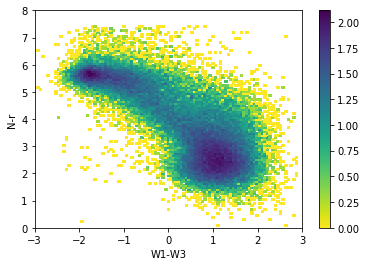

In [11]:
#Making a binned_data file...:

t = binned_statistic_2d(inf,opt,ind,statistic = 'count',bins = (100,100))

yedges = t[1]
xedges = t[2]
xbins = [0.5*(t[1][i] + t[1][i+1]) for i in range(25)]
ybins = [0.5*(t[2][i] + t[2][i+1]) for i in range(25)]
extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]

number = np.ma.array(t[0], mask = t[0] == 0)
number = np.log10(number)

plt.pcolormesh(yedges,xedges,(np.transpose(number)),cmap = plt.cm.viridis_r)
plt.colorbar()
# plt.xlim(0,0.056)
# plt.ylim(min(gr),max(gr))
plt.ylim(0,8.0)
plt.xlim(-3.0,3.0)
plt.xlabel('W1-W3')
plt.ylabel('N-r')
plt.show()





In [12]:
b = np.reshape(np.asarray(t[3]),(len(nsaid),1))
bins = np.unique(t[3])
new = np.column_stack((b,opt,inf,mass,lm,magsfr,magphys,uvsfr,uvssfr,env))
print(new[0:2])

new = new[new[:,0].argsort()]
n1 = [np.where(new[:,0] == bins[i]) for i in range(len(bins))]
print(new[0:2])
new1 =  np.array([np.mean(new[n1[i]], axis = 0) for i in range(len(bins))])
print(np.shape(new1))
print(new1[0:2])


[[ 8.10100000e+03  3.20956802e+00  1.61400127e+00  1.70285722e+10
   1.02311783e+01  1.45284585e-02 -1.02166498e+01  4.41372987e-01
  -9.78980530e+00  1.00000000e+00]
 [ 7.59000000e+03  3.08679771e+00  1.31699944e+00  2.12651776e+09
   9.32766914e+00 -1.01639575e+00 -1.03440649e+01 -1.87904968e-01
  -9.51557411e+00  1.00000000e+00]]
[[ 1.72000000e+02  5.14066601e+00 -2.90999985e+00  3.47769856e+09
   9.54129219e+00 -2.31882872e+00 -1.18601209e+01 -1.24470497e+00
  -1.07859972e+01  1.00000000e+00]
 [ 1.90000000e+02  6.54061127e+00 -2.95700073e+00  7.39745331e+09
   9.86908245e+00 -2.99388009e+00 -1.28629625e+01 -1.11146865e+00
  -1.09805511e+01  1.00000000e+00]]
(4294, 10)
[[ 1.72000000e+02  5.14066601e+00 -2.90999985e+00  3.47769856e+09
   9.54129219e+00 -2.31882872e+00 -1.18601209e+01 -1.24470497e+00
  -1.07859972e+01  1.00000000e+00]
 [ 1.90000000e+02  6.54061127e+00 -2.95700073e+00  7.39745331e+09
   9.86908245e+00 -2.99388009e+00 -1.28629625e+01 -1.11146865e+00
  -1.09805511e+01  1

In [13]:
#let's list the NSAID's for each of these bins, along with the "counts"
b = np.reshape(np.asarray(t[3]),(len(nsaid),1))
bins = np.unique(t[3])
li = np.column_stack((b,nsaid))
# print(new[0:2])

li = li[li[:,0].argsort()]
n1 = [np.where(li[:,0] == bins[i]) for i in range(len(bins))]
# print(li[0:2])

idlist = np.asarray([li[:,1][n1[i]] for i in range(len(bins))])

# print(idlist[0:10])

counts = np.asarray([len(li[:,1][n1[i]]) for i in range(len(bins))])


stuff = np.column_stack((new1,counts)).tolist()

stuff = [tuple(stuff[i]) for i in range(len(stuff))]
# afile = open(r'binned_counts_idlist.pkl', 'wb')
# pickle.dump(stuff2, afile)
# afile.close()

print(stuff[0])

print (np.shape(stuff))


(172.0, 5.1406660079956055, -2.9099998474121094, 3477698560.0, 9.541292190551758, -2.3188287230470053, -11.860120913598763, -1.2447049702074064, -10.785997160759164, 1.0, 1.0)
(4294, 11)


In [14]:
stuff3 = (np.array(stuff,dtype=[('bin','float'),('opt','float'),('inf','float'), 
                                ('mass','float'), ('logmass', 'float'),('magsfr','float'),
                                ('magphys','float'), ('uvsfr','float'), ('uv','float'), 
                                ('env', 'float'), ('counts', 'int')]) )

# afile = open(r'binned_data.pkl', 'wb')
# pickle.dump(stuff3, afile)
# afile.close()

print(stuff3[0:2])
print(np.shape(stuff3))
print(stuff3['bin'][0:10])



[(172., 5.14066601, -2.90999985, 3.47769856e+09, 9.54129219, -2.31882872, -11.86012091, -1.24470497, -10.78599716, 1., 1)
 (190., 6.54061127, -2.95700073, 7.39745331e+09, 9.86908245, -2.99388009, -12.86296255, -1.11146865, -10.9805511 , 1., 1)]
(4294,)
[172. 190. 273. 391. 586. 685. 883. 884. 888. 891.]


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


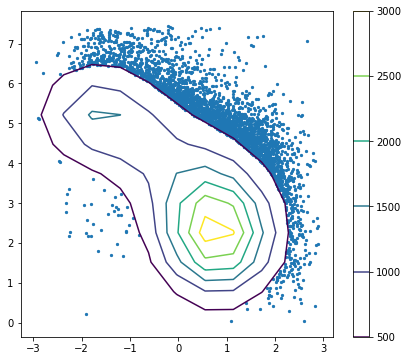

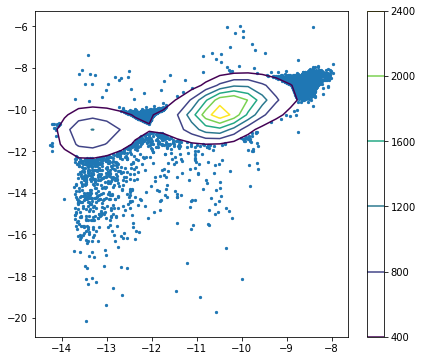

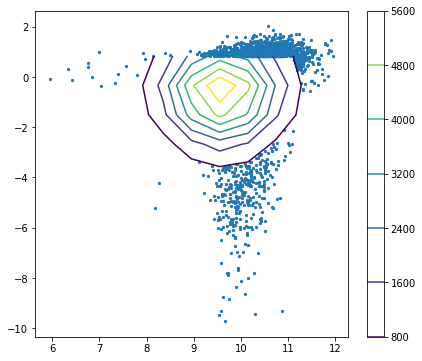

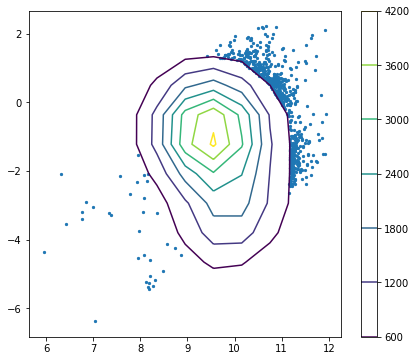

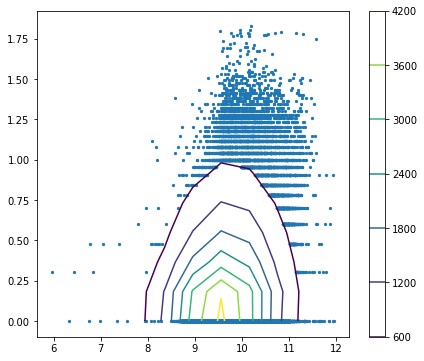

In [15]:

def scontour(x,y,n):
    try:
        from astropy.convolution import Gaussian2DKernel, convolve
        astro_smooth = True
    except ImportError as IE:
        astro_smooth = False

    H, xedges, yedges = np.histogram2d(x,y, bins=(np.int(n),np.int(n)))
    xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])

    # Smooth the contours (if astropy is installed)
    if astro_smooth:
        kernel = Gaussian2DKernel(stddev=1.)
        H=convolve(H,kernel)

    fig,ax = plt.subplots(1, figsize=(7,6)) 
    clevels = ax.contour(xmesh,ymesh,H.T, lw = 40)#,zorder=90)
    #ax.clabel(clevels)

    # Identify points within contours
    p = clevels.collections[0].get_paths()
    inside = np.full_like(x,False,dtype=bool)
    for level in p:
        inside |= level.contains_points(list(zip(*(x,y))))

    ax.scatter(x[~inside],y[~inside],s = 5)
    plt.colorbar(clevels)
    plt.show(block=False)

    
scontour(inf,opt,10)

scontour(magphys,uvssfr, 20)

scontour(lm,uvsfr, 10)

scontour(lm,magsfr, 10)

scontour(lm,np.log10(env), 10)

